## Upshot:
- I searched through the following corpora to see what kinds of transcript data and demographic details of the speakers (age, sex, etc) were available
- The best corpus I found is the CRECIL corpus, based on a Chinese sitcom from the 90s called "I love my family"
- This corpus, however, only labels the relations present within a given dialogue, but you are not able to see who is addressing who for each turn. This makes it complicated to work with dialogues containing many characters
- Fortunately, there are also a good number of dialogues with only 2 speakers, that also covers a wide variety of relations

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
from pathlib import Path
from tqdm import tqdm
import json

**CRECIL corpus**
- [paper](http://www.lrec-conf.org/proceedings/lrec2022/pdf/2022.lrec-1.250.pdf)
- [Github](https://github.com/bistu-nlp-lab/CRECIL)

In [2]:
with open('../CRECIL/Final_Data/train.json','r') as infile:
    train_df = json.loads(infile.read())
    
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(train_df))):

    raw_list = train_df[i][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

100%|██████████████████████████████████████| 482/482 [00:00<00:00, 27476.72it/s]

28.39% of "you"s are 您
2800 instances out of 9863


This is a pretty good distribution compared to other corpora I've explored. In many natural speech corpora (CallFriend, etc), the percent that is 您 is <1%.

Something just dawning on me now: in the transcript with multiple people, it's not super clear who each line is being directed _at_. This is a problem, because that's the signal that I'm hoping will tell me how formality is being used. However it seems like this is equality important for relation extraction, so I can learn how the baseline/other approaches resolve this. 

On the other hand, there might be dialogues with only 2 speakers, in which case I can assume they are talking to each other. 

Text(0.5, 0.98, 'No. of dialogs by no. of speakers in dialog')

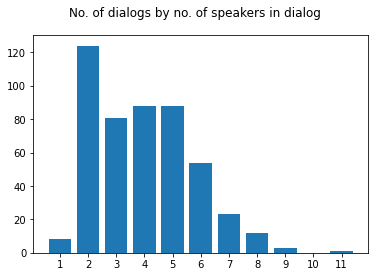

In [3]:
#Find number of speakers per dialogue, and visualize
dialog_chars = Counter()
len_dict = Counter()

for i in range(0,len(train_df)):
    char_set = set()
    for j in range(0,len(train_df[i][0])):
        char_set.add(re.findall('.*(?<=:)',train_df[i][0][j])[0])
    dialog_chars[i] = len(char_set)
    
    if len(char_set) not in len_dict:
        len_dict[len(char_set)] = 0
    len_dict[len(char_set)] += 1

#No. of dialogs by no. of speakers in dialog
plot = plt.bar(len_dict.keys(),len_dict.values())
plt.xticks(range(1, len(len_dict.values())+2))
plt.suptitle("No. of dialogs by no. of speakers in dialog")

Text(0.5, 0.98, 'Relations annotated in 2-person dialogs')

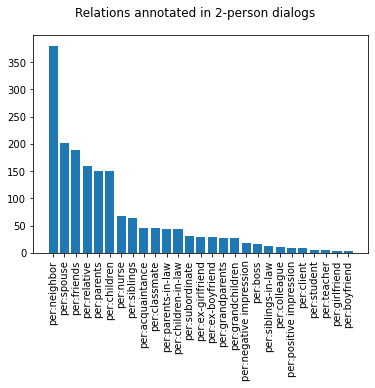

In [4]:
#display the main relations present in 2-person dialogs
pair_dialog_indices = [i for i in list(dialog_chars.keys()) if dialog_chars[i]==2]

all_roles = dict()
for dg in pair_dialog_indices:
    for i in range(0,len(train_df[dg][1])):
        if train_df[dg][1][i]['r'][0] not in all_roles:
            all_roles[train_df[dg][1][i]['r'][0]] = 0
        all_roles[train_df[dg][1][i]['r'][0]] += 1     
        
all_roles_list = sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

ignore_relations = ['unanswerable','per:alternate_name']
all_roles_keys = [item[0] for item in all_roles_list if item[0] not in ignore_relations]
all_roles_values = [item[1] for item in all_roles_list if item[0] not in ignore_relations]

plt.xticks(rotation=90)
plt.bar(all_roles_keys,all_roles_values)

plt.suptitle("Relations annotated in 2-person dialogs")

**Notes**:
- There is some double-counting from the inverse of the same relationship being recorded (e.g. per:parents and per:children have same counts)
- There are a few strange relations such as 'per:negative impression' which I will need to understand better
- Overall though, a good distribution of relations

In [8]:
#sample dialogue 1
train_df[pair_dialog_indices[0]][0]

['S 1: 小张啊，你得有现代意识，挣了钱老存着，怎么也是个死的，资金一定要流动，你看，这回呀，我跟爷爷合伙做了笔生意，嗯，弄好了呢，能挣大钱……',
 'S 2: 小凡姐，这样的好事儿，你总忘了叫我',
 'S 1: 现在也不晚呐，我给您来了内部调济，我来了十股，你来多少？',
 'S 2: 那，我也跟你，入一股，给，两块',
 'S 1: 这就对了嘛，我给你打一条去']

In [10]:
#sample dialogue 2
train_df[pair_dialog_indices[1]][0][0:5]

['S 1: 这位同志，这位同志，您都跟了我一道了，您怎么还跟家里来了？你赶紧出去，您不出去我报警了我！……',
 'S 2: 您这儿是生活之友吧，杨柳北里十八号？',
 'S 1: 他们把广告登错了，我们正准备打电话更正呢。',
 'S 2: 您就甭谦虚了。我一看见您，我就知道，您是大夫……',
 'S 1: 我不是，得，那我就甭谦虚了，我就冒充一回大夫吧，您坐，您说吧，您哪不好啊？']

In [9]:
ni_count = 0
nin_count = 0

for i in range(0,len(pair_dialog_indices)):

    raw_list = train_df[pair_dialog_indices[i]][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

25.47% of "you"s are 您
595 instances out of 2336


Note the similar 你/您 split as for the overall corpus

In [10]:
pair_dialog_df = [train_df[i] for i in pair_dialog_indices]
pair_dialog_df[8][0][0:7]

['S 1: 喽？这是干什么呀？',
 'S 2: 志新放出来好几天了，我们想请胡伯伯跟胡伯母啊，过来吃顿饭',
 'S 1: 请他们干什么？',
 'S 2: 嗯？',
 'S 1: 志新放出来，是海南方面把问题搞清楚了嘛，他们总经理开车撞的人，他们当然要放啦，跟他胡学范有什么关系',
 'S 2: 爸，您怎么过河拆桥啊？',
 'S 1: 别人的桥，可以不拆，他的桥我还非拆不可，这个事件办成了，应该感谢政府感谢党嘛，用的着感谢胡学范嘛，都是你们，非得让我去求他']

In [10]:
pair_dialog_df[8][1][0:7]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 1', 'y': '志新', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 1',
  'y': '胡伯伯',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1', 'y': '胡伯母', 'r': ['per:friends'], 'rid': [11]},
 {'x': 'S 1',
  'y': '胡学范',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1',
  'y': '老胡',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]}]

Here, and in a few other examples, it looks like the relation annotation is in reverse order. From the dialogue, S2 says, "爸..." to S1, whereas the relation annotated is <br/>
<br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] <br/>
<br/>
These examples, as well as the diagram in [this image](https://github.com/bistu-nlp-lab/CRECIL), leads me to believe that relations are annotated as "x is the per:_relation_ of y", or "S1 is the _parents-in-law_ of S2" <br/>
<br/>
With this, I can make a dataframe with variables= _text_, _speaker-addressee-relation_

In [11]:
pair_df = []

for item in pair_dialog_df:
    

    S1_title = ''
    S2_title = ''

    for rel in item[1]:

        if rel['x']=='S 1' and rel['y']=='S 2':

            S1_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S1_title)>0: 
                S1_title=S1_title[0]

        if rel['y']=='S 1' and rel['x']=='S 2':

            S2_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S2_title)>0: 
                S2_title=S2_title[0]

        if len(S1_title)>0 and len(S2_title)>0:

            S1_relation = S1_title+":"+S2_title
            S2_relation = S2_title+":"+S1_title

            for line in item[0]:
                party = re.findall('^S\s[1-2]',line)
                if len(party)>0: 
                    party=party[0]

                    if party =='S 1':
                        pair_df.append((line,S1_relation))
                    elif party=='S 2':
                        pair_df.append((line,S2_relation))

pair_df = pd.DataFrame(list(pair_df),columns=['text','relation'])

In [9]:
Counter(pair_df.relation).most_common()

[('spouse:spouse', 9637),
 ('friends:friends', 5821),
 ('children-in-law:parents-in-law', 5705),
 ('parents-in-law:children-in-law', 5576),
 ('neighbor:neighbor', 4026),
 ('relative:relative', 2684),
 ('classmate:classmate', 2552),
 ('children:parents', 1178),
 ('parents:children', 1158),
 ('subordinate:nurse', 765),
 ('nurse:subordinate', 741),
 ('grandparents:grandchildren', 546),
 ('grandchildren:grandparents', 532),
 ('acquaintance:acquaintance', 504),
 ('siblings:siblings', 490)]

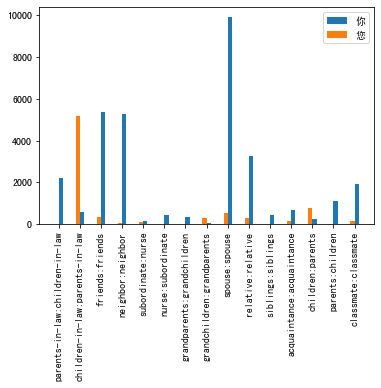

In [12]:
rel_dict = dict()
for rel in list(pair_df.relation.unique()):
    rel_dict[rel]=dict()
    rel_dict[rel]['你']=0
    rel_dict[rel]['您']=0
    
for i in range(0,len(pair_df)):
        
    rel_dict[pair_df.relation.iloc[i]]['你'] += len(re.findall('你',pair_df.text.iloc[i]))
    rel_dict[pair_df.relation.iloc[i]]['您'] += len(re.findall('您',pair_df.text.iloc[i]))
    
#reverse the order of the nested keys in rel_dict
rel_dict_2 = dict()
rel_dict_2['你'] = dict()
rel_dict_2['您'] = dict()

for item in rel_dict:
    rel_dict_2['你'][item] = rel_dict[item]['你']
    rel_dict_2['您'][item] = rel_dict[item]['您']
    
from matplotlib import font_manager


plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(rel_dict_2['你'].keys(), rel_dict_2['你'].values(), width=0.2, align='edge', label='你')
ax.bar(rel_dict_2['您'].keys(), rel_dict_2['您'].values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()

In [13]:
#Present data as an observation table
rel_df = pd.DataFrame(rel_dict_2)
rel_df

,你,您
parents-in-law:children-in-law,2218,4
children-in-law:parents-in-law,588,5159
friends:friends,5387,353
neighbor:neighbor,5292,79
subordinate:nurse,172,100
nurse:subordinate,422,0
grandparents:grandchildren,320,0
grandchildren:grandparents,38,275
spouse:spouse,9910,512
relative:relative,3261,283


I can use the Pearson’s Chi-Square test to test independence between the variables, in this case represented by the direction of speaker-to-addressee. This is analagous to the scenario tested [here](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)

In [14]:
from scipy.stats import chi2_contingency

# defining the table
stat, p, dof, expected = chi2_contingency(rel_df)
 
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


##### Subtask
Get relationship mappings of all characters in the show <br/>
-> found in ../CRECIL/Orginal_data/relation/relation.txt

In [5]:
with open('../CRECIL/Orginal_data/relation/relation.txt','r') as infile:
    relations_txt = infile.read()
relations_txt.split('\n')[0:5]

["('小晴', '表妹')\t['per:alternate_name']",
 "('大壮', '秀芳')\t['per:children']",
 "('秀芳', '大壮')\t['per:parents']",
 "('许警察', '于大妈')\t['per:acquaintance']",
 "('小许', '许警察')\t['per:alternate_name']"]

In [7]:
#Put into pandas format. Remember that the relation is A is stated relation (e.g. parent) of B
#test = "('小晴', '表妹')\t['per:alternate_name']"
#re.findall("'.*?'",test)[2]

A = []
B = []
relations = []
pattern = re.compile("'.*?'")
for line in relations_txt.split('\n'):
    if len(line)>0:
        A.append(pattern.findall(line)[0].replace("'",""))
        B.append(pattern.findall(line)[1].replace("'",""))
        relations.append(pattern.findall(line)[2].replace("'",""))
all_relations = pd.DataFrame(list(zip(A,B,relations)),columns = ['A','B','relation'])


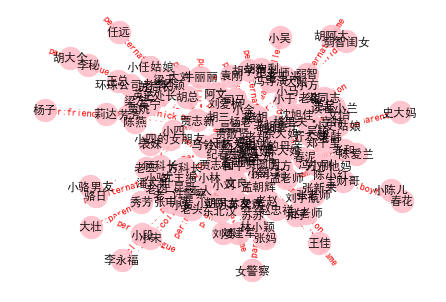

In [8]:
#try to graph the characters and relations in a network
import networkx as nx
from matplotlib import font_manager

G = nx.Graph()
G.add_nodes_from([item for item in set(all_relations.A)])
G.add_edges_from([(all_relations.A.iloc[i],all_relations.B.iloc[i]) for i in range(0,len(all_relations))])

edge_labs = dict()
for i in range(0,len(all_relations)):
    edge_labs[(all_relations.A.iloc[i],all_relations.B.iloc[i])] = all_relations.relation.iloc[i] 
    


plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

Far too many, maybe limit to the top 10 -> Actually 8 looks better

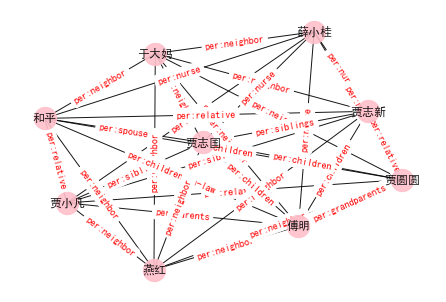

In [9]:
list_a = [item[0] for item in Counter(all_relations.A).most_common(8)]
list_b = [item[0] for item in Counter(all_relations.B).most_common(8)]
some_relations = all_relations[all_relations.A.isin(list_a)&all_relations.B.isin(list_b)] 

G = nx.Graph()
G.add_nodes_from([item for item in set(some_relations.A)])
G.add_edges_from([(some_relations.A.iloc[i],some_relations.B.iloc[i]) for i in range(0,len(some_relations))])
edge_labs = dict()
for i in range(0,len(some_relations)):
    edge_labs[(some_relations.A.iloc[i],some_relations.B.iloc[i])] = some_relations.relation.iloc[i] 

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

Subtask
Find sentences in original data between known relationships